In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [14]:

def plot_rashomon_results(results_df, thresholds=[0.01, 0.05], save_plots=True):
    """
    Create comprehensive plots for Rashomon simulation results.
    
    Parameters:
    -----------
    results_df : pandas.DataFrame
        Results from run_rashomon_simulation()
    thresholds : list
        List of thresholds used in simulation
    save_plots : bool
        Whether to save plots to files
    """
    
    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Create figure with subplots
    n_thresholds = len(thresholds)
    fig = plt.figure(figsize=(16, 12))
    
    # Plot 1: Rashomon Set Size vs Sample Size
    plt.subplot(2, 3, 1)
    for threshold in thresholds:
        col_name = f'count_{int(threshold*100)}pct'
        
        # Calculate mean and std for each sample size
        summary_stats = results_df.groupby('sample_size')[col_name].agg(['mean', 'std']).reset_index()
        
        plt.errorbar(summary_stats['sample_size'], 
                    summary_stats['mean'],
                    yerr=summary_stats['std'],
                    marker='o', 
                    label=f'{threshold*100:.1f}% threshold',
                    capsize=5)
    
    plt.xlabel('Sample Size')
    plt.ylabel('Average Rashomon Set Size')
    plt.title('Rashomon Set Size vs Sample Size')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xscale('log')
    
    # Plot 2: True DGP Recovery Rate vs Sample Size
    plt.subplot(2, 3, 2)
    dgp_recovery_stats = results_df.groupby('sample_size')['best_is_true_dgp'].agg(['mean', 'std']).reset_index()
    
    plt.errorbar(dgp_recovery_stats['sample_size'],
                dgp_recovery_stats['mean'],
                yerr=dgp_recovery_stats['std'],
                marker='s',
                color='red',
                capsize=5,
                linewidth=2)
    
    plt.xlabel('Sample Size')
    plt.ylabel('Probability Best Model = True DGP')
    plt.title('True Model Recovery Rate')
    plt.grid(True, alpha=0.3)
    plt.xscale('log')
    plt.ylim(0, 1)
    
    # Plot 3: DGP in Rashomon Set vs Sample Size
    plt.subplot(2, 3, 3)
    for threshold in thresholds:
        dgp_col = f'dgp_in_rashomon_{int(threshold*100)}pct'
        
        dgp_rashomon_stats = results_df.groupby('sample_size')[dgp_col].agg(['mean', 'std']).reset_index()
        
        plt.errorbar(dgp_rashomon_stats['sample_size'],
                    dgp_rashomon_stats['mean'],
                    yerr=dgp_rashomon_stats['std'],
                    marker='d',
                    label=f'{threshold*100:.1f}% threshold',
                    capsize=5)
    
    plt.xlabel('Sample Size')
    plt.ylabel('Probability DGP in Rashomon Set')
    plt.title('True Model in Rashomon Set')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xscale('log')
    plt.ylim(0, 1)
    
    # Plot 4: Distribution of Rashomon Set Sizes (for largest sample size)
    plt.subplot(2, 3, 4)
    largest_sample = results_df['sample_size'].max()
    largest_sample_data = results_df[results_df['sample_size'] == largest_sample]
    
    for i, threshold in enumerate(thresholds):
        col_name = f'count_{int(threshold*100)}pct'
        plt.hist(largest_sample_data[col_name], 
                alpha=0.7, 
                bins=20, 
                label=f'{threshold*100:.1f}% threshold',
                density=True)
    
    plt.xlabel('Rashomon Set Size')
    plt.ylabel('Density')
    plt.title(f'Distribution of Rashomon Sizes\n(Sample Size = {largest_sample})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 5: Recovery rates by sample size (bar plot)
    plt.subplot(2, 3, 5)
    sample_sizes = sorted(results_df['sample_size'].unique())
    recovery_rates = [results_df[results_df['sample_size'] == ss]['best_is_true_dgp'].mean() 
                     for ss in sample_sizes]
    
    bars = plt.bar(range(len(sample_sizes)), recovery_rates, 
                   color='lightcoral', alpha=0.7, edgecolor='black')
    plt.xlabel('Sample Size')
    plt.ylabel('True Model Recovery Rate')
    plt.title('Recovery Rate by Sample Size')
    plt.xticks(range(len(sample_sizes)), [f'{ss}' for ss in sample_sizes], rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, rate in zip(bars, recovery_rates):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{rate:.2f}', ha='center', va='bottom')
    
    # Plot 6: Correlation plot (Recovery vs Rashomon size)
    plt.subplot(2, 3, 6)
    for threshold in thresholds:
        count_col = f'count_{int(threshold*100)}pct'
        dgp_col = f'dgp_in_rashomon_{int(threshold*100)}pct'
        
        # Calculate correlation by sample size
        corr_by_sample = []
        sample_sizes_for_corr = []
        
        for ss in sorted(results_df['sample_size'].unique()):
            subset = results_df[results_df['sample_size'] == ss]
            if len(subset) > 1:  # Need at least 2 points for correlation
                corr = subset['best_is_true_dgp'].corr(subset[dgp_col])
                if not np.isnan(corr):
                    corr_by_sample.append(corr)
                    sample_sizes_for_corr.append(ss)
        
        if corr_by_sample:
            plt.plot(sample_sizes_for_corr, corr_by_sample, 
                    marker='o', label=f'{threshold*100:.1f}% threshold')
    
    plt.xlabel('Sample Size')
    plt.ylabel('Correlation: Recovery vs DGP in Rashomon')
    plt.title('Recovery-Rashomon Correlation')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xscale('log')
    
    plt.tight_layout()
    
    if save_plots:
        plt.savefig('rashomon_simulation_plots.png', dpi=300, bbox_inches='tight')
        print("Plots saved to rashomon_simulation_plots.png")
    
    plt.show()

def plot_detailed_analysis(results_df, thresholds=[0.01]):
    """
    Create additional detailed analysis plots.
    """
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: Heatmap of recovery rates
    pivot_data = results_df.groupby(['sample_size'])['best_is_true_dgp'].mean().reset_index()
    
    # Create a pivot table for heatmap (if you have multiple thresholds)
    if len(thresholds) > 1:
        heatmap_data = []
        for threshold in thresholds:
            dgp_col = f'dgp_in_rashomon_{int(threshold*100)}pct'
            threshold_data = results_df.groupby('sample_size')[dgp_col].mean()
            heatmap_data.append(threshold_data.values)
        
        heatmap_df = pd.DataFrame(heatmap_data, 
                                 index=[f'{t*100:.1f}%' for t in thresholds],
                                 columns=[f'{ss}' for ss in sorted(results_df['sample_size'].unique())])
        
        sns.heatmap(heatmap_df, annot=True, fmt='.3f', ax=axes[0,0], cmap='YlOrRd')
        axes[0,0].set_title('DGP in Rashomon Set Rate')
        axes[0,0].set_xlabel('Sample Size')
        axes[0,0].set_ylabel('Threshold')
    else:
        # Single threshold - show recovery rate by sample size
        sample_sizes = sorted(results_df['sample_size'].unique())
        recovery_by_size = [results_df[results_df['sample_size'] == ss]['best_is_true_dgp'].mean() 
                           for ss in sample_sizes]
        
        axes[0,0].bar(range(len(sample_sizes)), recovery_by_size, color='skyblue', alpha=0.7)
        axes[0,0].set_xticks(range(len(sample_sizes)))
        axes[0,0].set_xticklabels([str(ss) for ss in sample_sizes])
        axes[0,0].set_title('True Model Recovery Rate by Sample Size')
        axes[0,0].set_xlabel('Sample Size')
        axes[0,0].set_ylabel('Recovery Rate')
    
    # Plot 2: Box plot of Rashomon sizes by sample size
    threshold = thresholds[0]  # Use first threshold
    col_name = f'count_{int(threshold*100)}pct'
    
    sample_size_data = []
    sample_size_labels = []
    for ss in sorted(results_df['sample_size'].unique()):
        subset = results_df[results_df['sample_size'] == ss]
        sample_size_data.append(subset[col_name].values)
        sample_size_labels.append(str(ss))
    
    axes[0,1].boxplot(sample_size_data, labels=sample_size_labels)
    axes[0,1].set_title(f'Rashomon Set Size Distribution\n({threshold*100:.1f}% threshold)')
    axes[0,1].set_xlabel('Sample Size')
    axes[0,1].set_ylabel('Rashomon Set Size')
    axes[0,1].grid(True, alpha=0.3)
    
    # Plot 3: Scatter plot - sample size vs metrics
    axes[1,0].scatter(results_df['sample_size'], results_df['best_is_true_dgp'], 
                     alpha=0.6, s=20, color='red', label='Best = DGP')
    
    dgp_col = f'dgp_in_rashomon_{int(threshold*100)}pct'
    axes[1,0].scatter(results_df['sample_size'], results_df[dgp_col], 
                     alpha=0.6, s=20, color='blue', label='DGP in Rashomon')
    
    axes[1,0].set_xlabel('Sample Size')
    axes[1,0].set_ylabel('Binary Outcome')
    axes[1,0].set_title('Individual Simulation Results')
    axes[1,0].legend()
    axes[1,0].set_xscale('log')
    axes[1,0].grid(True, alpha=0.3)
    
    # Plot 4: Summary table as text
    axes[1,1].axis('off')
    
    # Create summary statistics
    summary_text = "SIMULATION SUMMARY\n" + "="*30 + "\n\n"
    
    for ss in sorted(results_df['sample_size'].unique()):
        subset = results_df[results_df['sample_size'] == ss]
        recovery_rate = subset['best_is_true_dgp'].mean()
        dgp_in_rashomon_rate = subset[dgp_col].mean()
        avg_rashomon_size = subset[col_name].mean()
        
        summary_text += f"Sample Size {ss}:\n"
        summary_text += f"  Recovery Rate: {recovery_rate:.3f}\n"
        summary_text += f"  DGP in Rashomon: {dgp_in_rashomon_rate:.3f}\n"
        summary_text += f"  Avg Rashomon Size: {avg_rashomon_size:.1f}\n\n"
    
    axes[1,1].text(0.05, 0.95, summary_text, transform=axes[1,1].transAxes,
                   fontsize=10, verticalalignment='top', fontfamily='monospace')
    
    plt.tight_layout()
    plt.show()

# Example usage function
def create_all_plots(results_df, thresholds=[0.01]):
    """
    Create all plots for the Rashomon simulation results.
    """
    print("Creating main plots...")
    plot_rashomon_results(results_df, thresholds)
    
    print("Creating detailed analysis plots...")
    plot_detailed_analysis(results_df, thresholds)
    
    print("All plots created!")

# Quick plotting function for testing
def quick_plot_test():
    """
    Test the plotting functions with sample data.
    """
    # Create some sample data for testing
    np.random.seed(42)
    n_samples = 400
    sample_sizes = [50, 1000, 5000, 10000]
    
    test_data = {
        'sample_size': np.repeat(sample_sizes, n_samples // len(sample_sizes)),
        'iteration': np.tile(range(n_samples // len(sample_sizes)), len(sample_sizes)),
        'best_is_true_dgp': np.random.binomial(1, 0.3, n_samples),
        'count_1pct': np.random.poisson(5, n_samples),
        'dgp_in_rashomon_1pct': np.random.binomial(1, 0.8, n_samples)
    }
    
    test_df = pd.DataFrame(test_data)
    
    print("Running plotting test with sample data...")
    plot_rashomon_results(test_df, thresholds=[0.01], save_plots=False)
    
    return test_df

In [18]:
# load data
df = pd.read_csv('../results/bootstrap_sim_big.csv')

/Users/adam/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


Plots saved to rashomon_simulation_plots.png


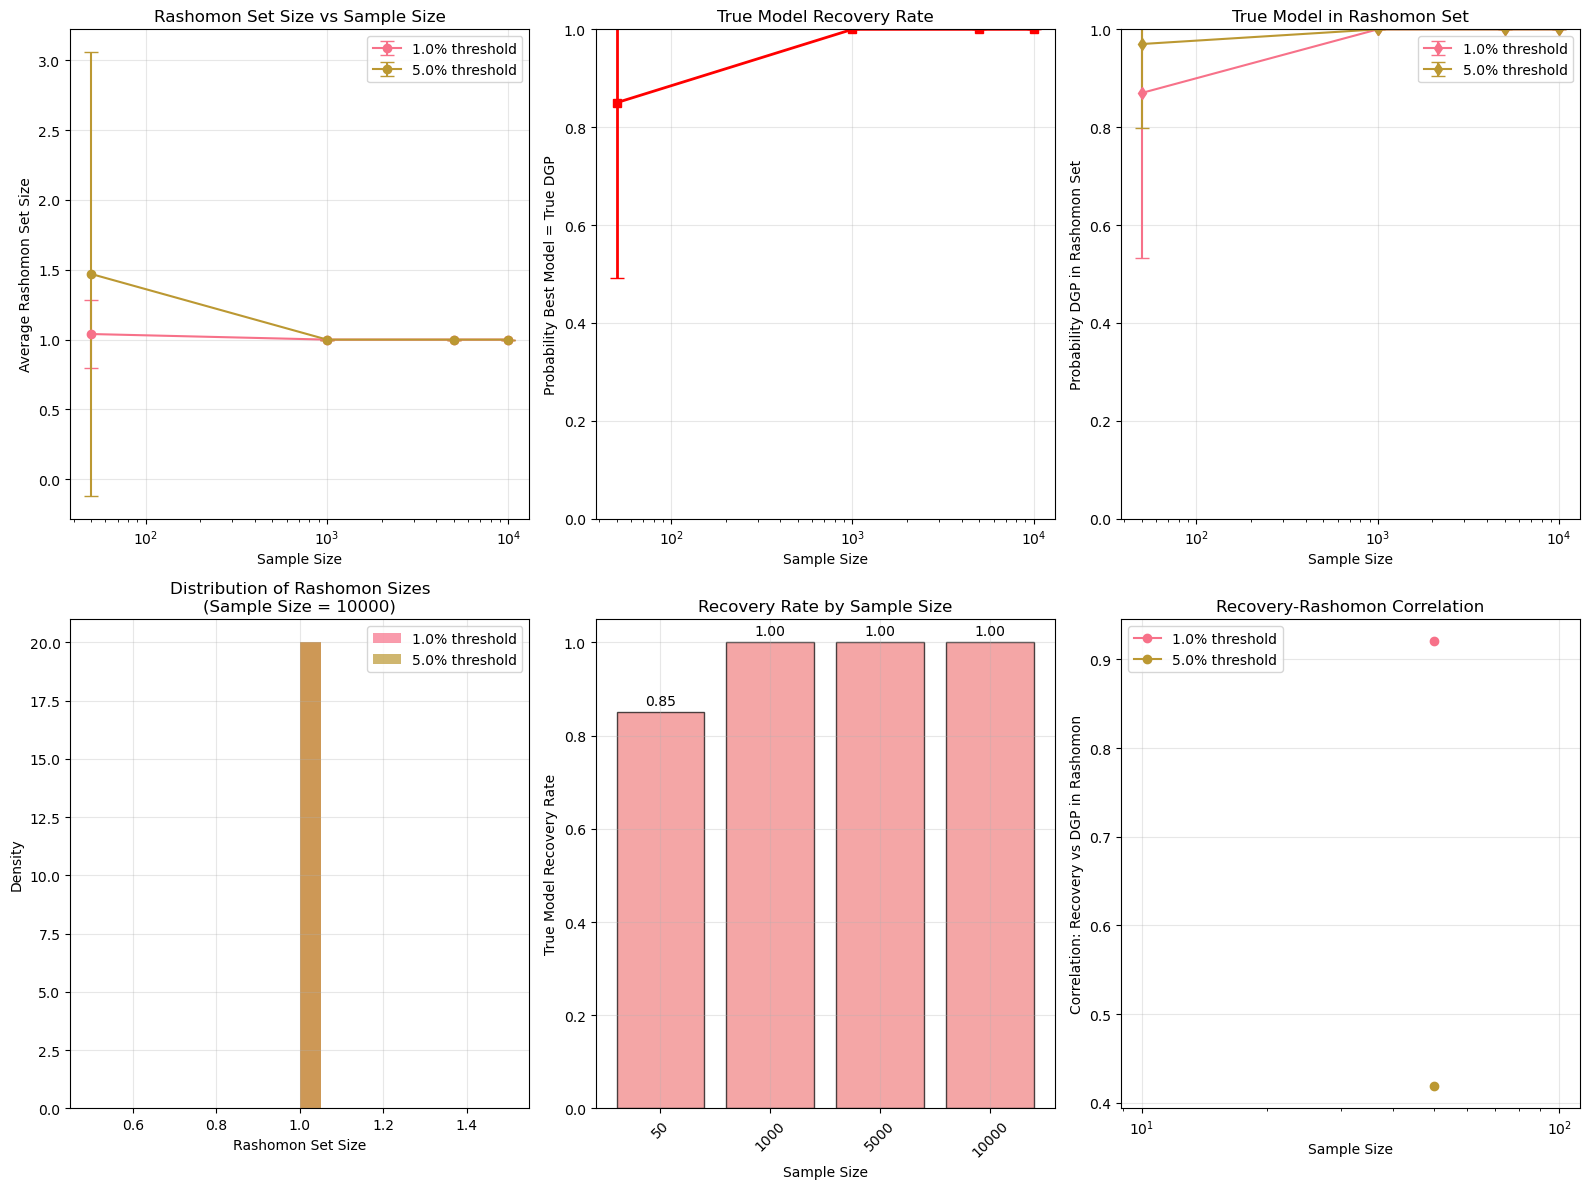

In [19]:
# he main plots
plot_rashomon_results(results_df = df, thresholds=[0.01, 0.05])

Creating main plots...


/Users/adam/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


Plots saved to rashomon_simulation_plots.png


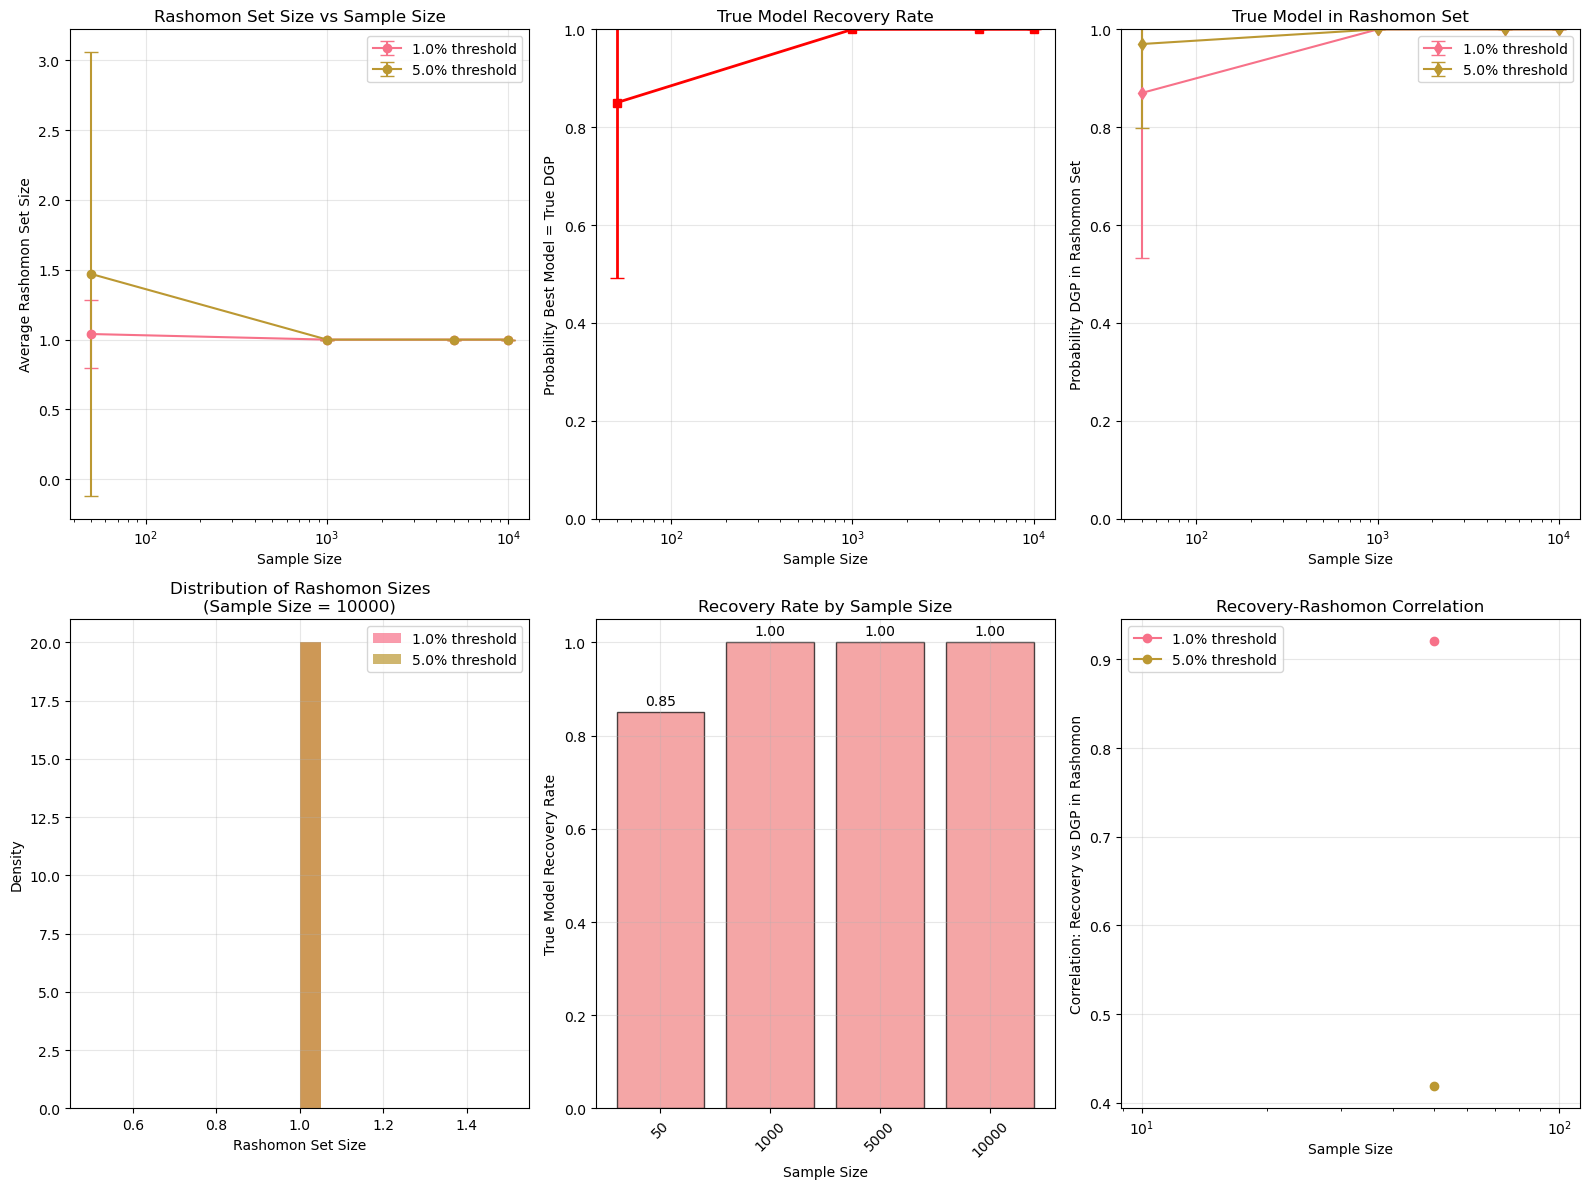

Creating detailed analysis plots...


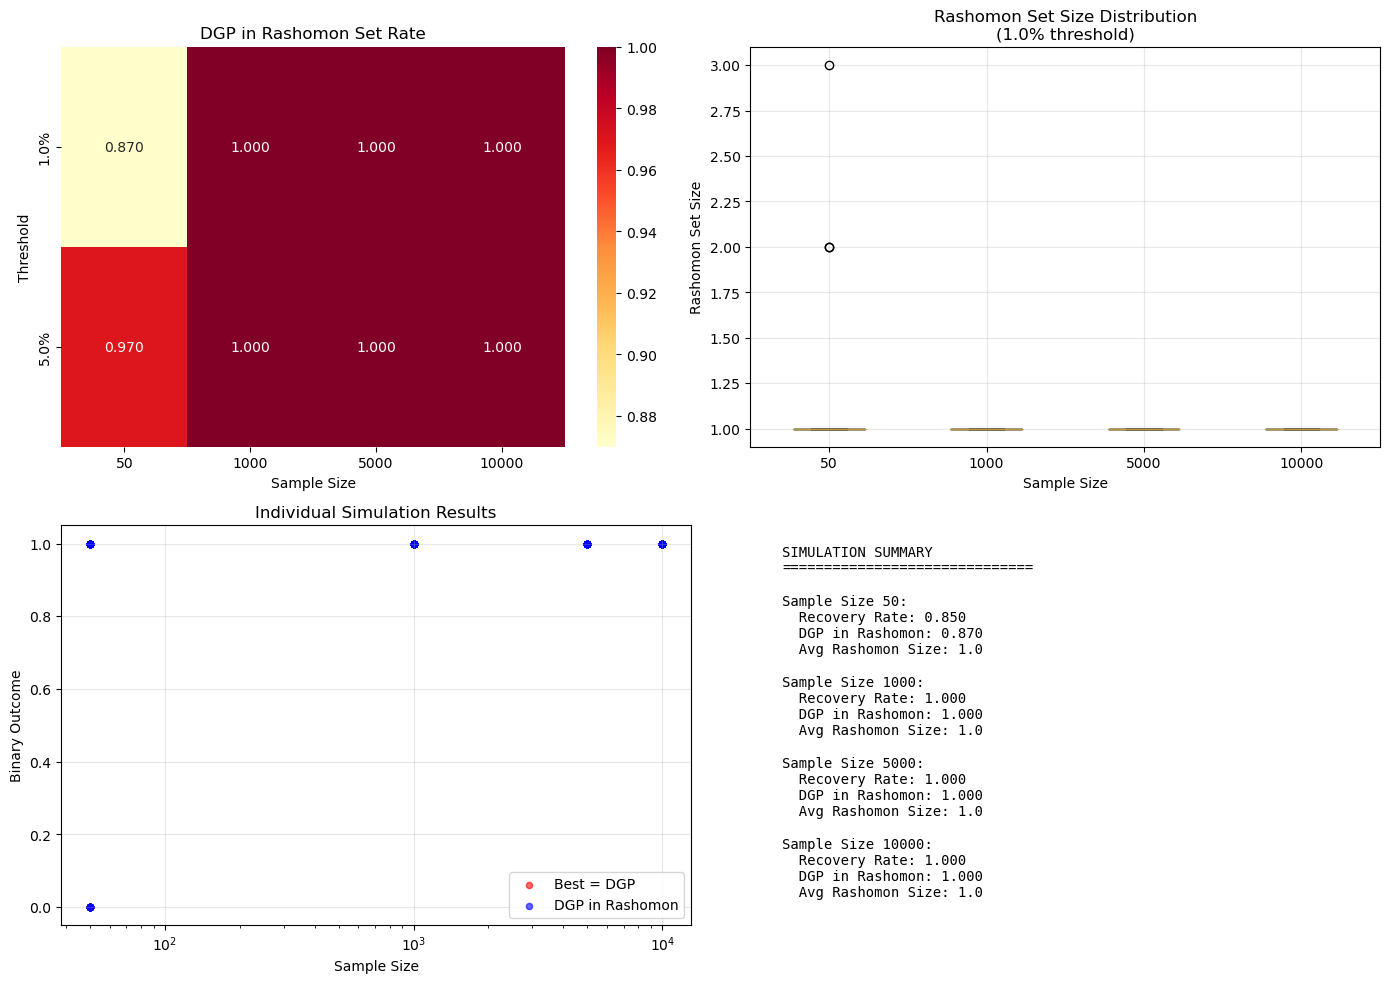

All plots created!


In [20]:
# Create all plots
create_all_plots(results_df = df, thresholds=[0.01, 0.05])

Loading results from bootstrap_rashomon_results.csv...
Saved plots: rashomon_set_distributions.png/pdf


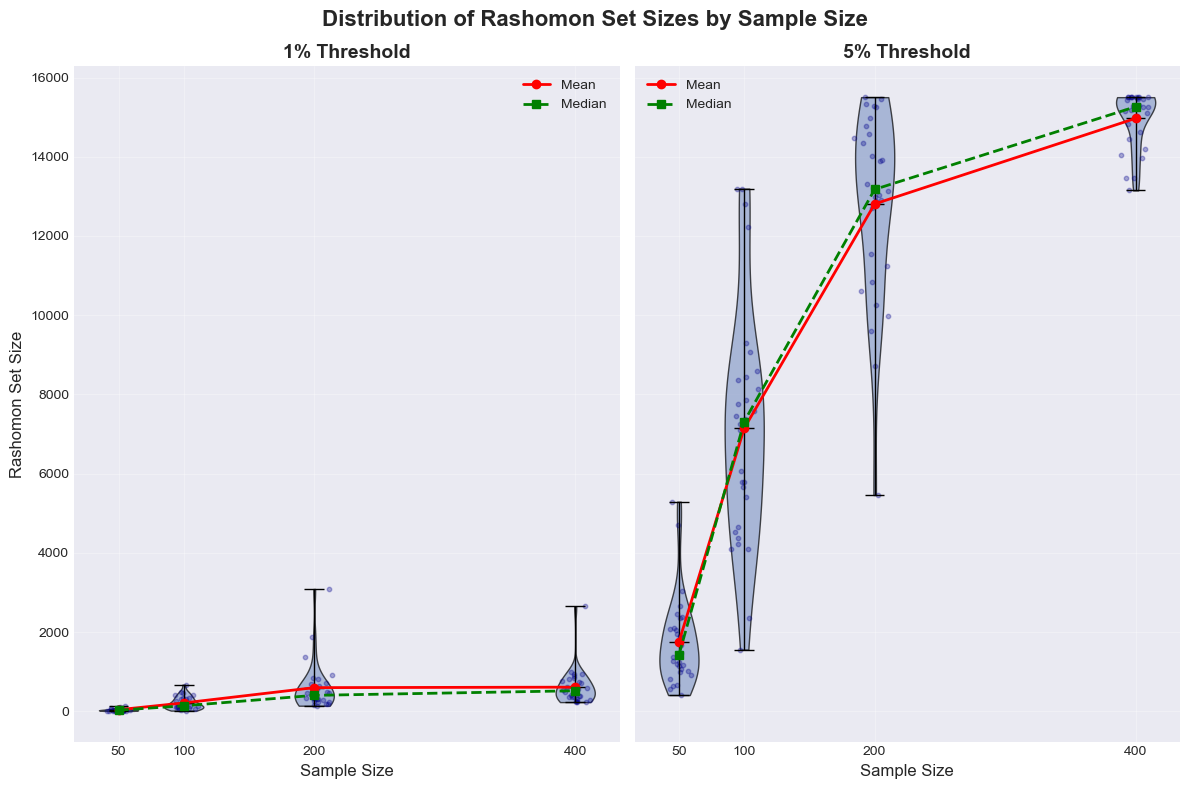

Saved plots: rashomon_set_boxplots.png/pdf


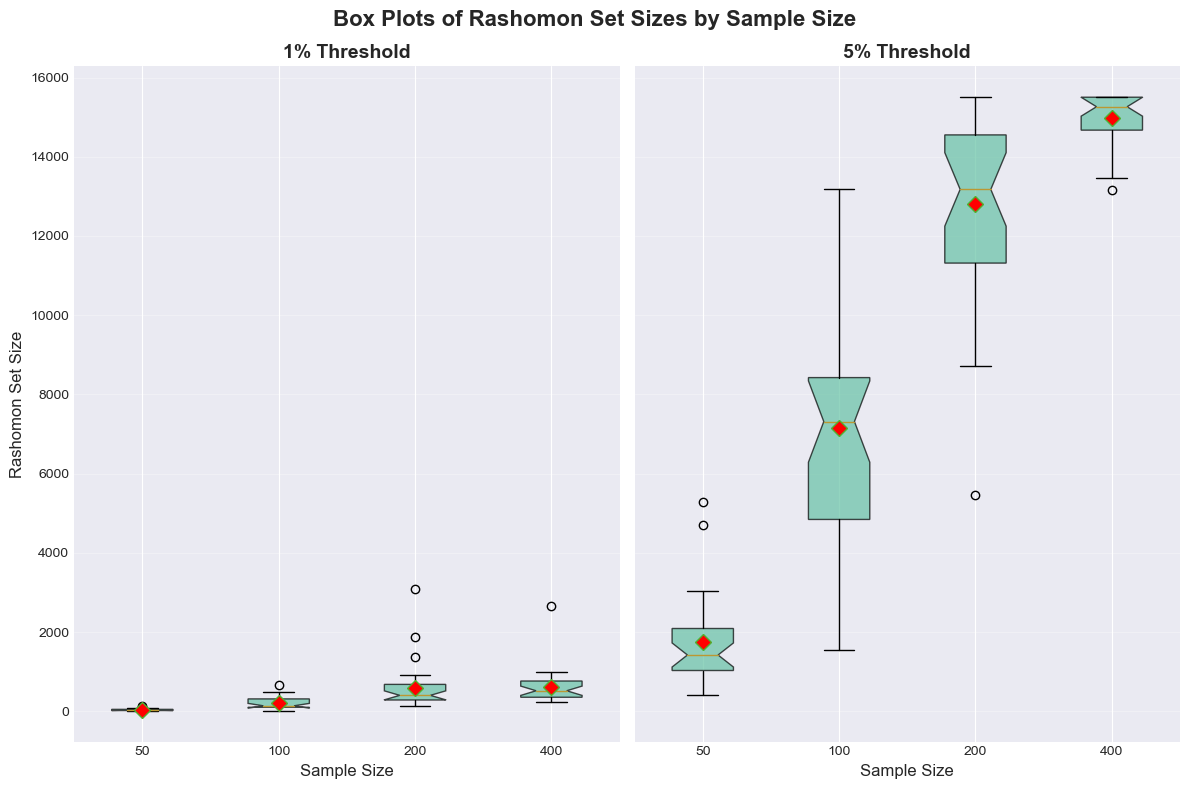

Saved plots: rashomon_set_summary.png/pdf


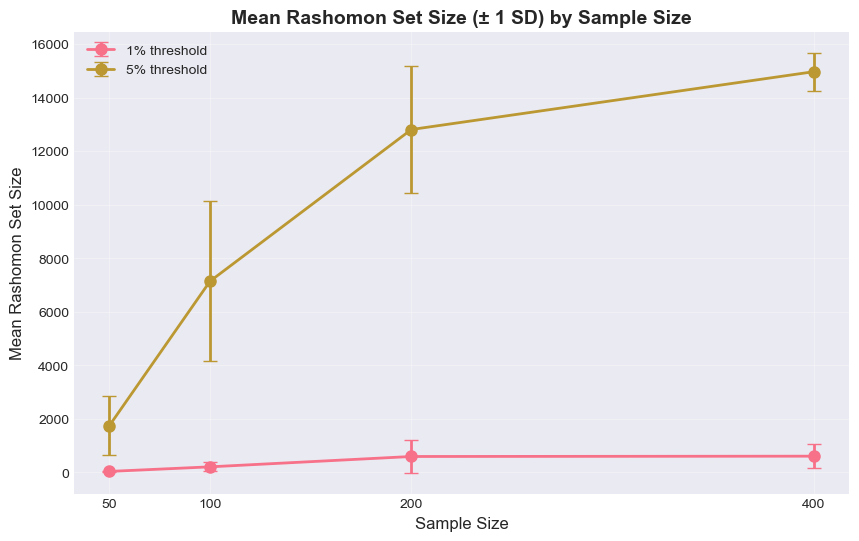


SUMMARY STATISTICS

1% Threshold:
  Sample size 50:
    Mean: 37.8
    Std:  31.7
    Min:  8
    Q1:   17
    Med:  27
    Q3:   47
    Max:  141
  Sample size 100:
    Mean: 209.1
    Std:  162.0
    Min:  15
    Q1:   99
    Med:  136
    Q3:   311
    Max:  671
  Sample size 200:
    Mean: 595.5
    Std:  601.1
    Min:  139
    Q1:   283
    Med:  400
    Q3:   678
    Max:  3086
  Sample size 400:
    Mean: 607.2
    Std:  454.1
    Min:  230
    Q1:   352
    Med:  516
    Q3:   763
    Max:  2647

5% Threshold:
  Sample size 50:
    Mean: 1749.3
    Std:  1113.9
    Min:  408
    Q1:   1028
    Med:  1420
    Q3:   2088
    Max:  5290
  Sample size 100:
    Mean: 7142.6
    Std:  2989.0
    Min:  1554
    Q1:   4842
    Med:  7313
    Q3:   8424
    Max:  13195
  Sample size 200:
    Mean: 12808.2
    Std:  2366.4
    Min:  5459
    Q1:   11314
    Med:  13176
    Q3:   14552
    Max:  15504
  Sample size 400:
    Mean: 14968.9
    Std:  713.1
    Min:  13149
    Q1:   14671
 

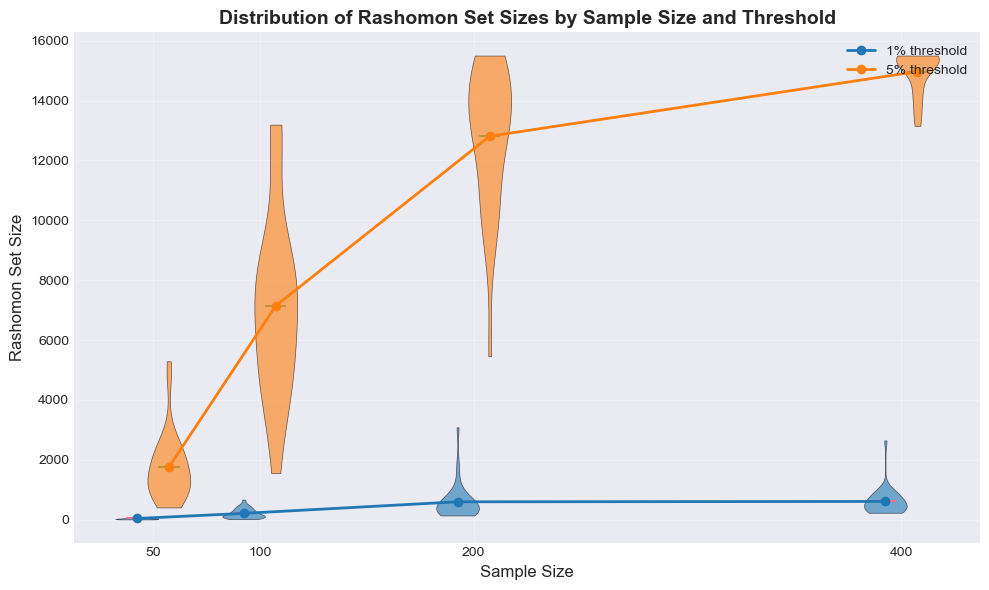

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

def load_and_plot_rashomon_results(results_file='bootstrap_rashomon_results.csv',
                                   summary_file='bootstrap_rashomon_summary.csv',
                                   thresholds=[0.01, 0.05],
                                   figsize=(12, 8),
                                   save_plots=True):
    """
    Load bootstrap results and create plots showing the distribution of Rashomon set sizes.
    
    Parameters:
    -----------
    results_file : str
        Path to the detailed results CSV file
    summary_file : str
        Path to the summary statistics CSV file
    thresholds : list
        List of thresholds to plot (should match those used in the analysis)
    figsize : tuple
        Figure size for plots
    save_plots : bool
        Whether to save plots to files
    """
    
    # Load data
    print(f"Loading results from {results_file}...")
    results_df = pd.read_csv(results_file)
    summary_df = pd.read_csv(summary_file)
    
    # Set style
    plt.style.use('seaborn-v0_8-darkgrid')
    sns.set_palette("husl")
    
    # Create subplots for each threshold
    n_thresholds = len(thresholds)
    fig, axes = plt.subplots(1, n_thresholds, figsize=figsize, sharey=True)
    if n_thresholds == 1:
        axes = [axes]
    
    sample_sizes = sorted(results_df['sample_size'].unique())
    
    for idx, threshold in enumerate(thresholds):
        ax = axes[idx]
        col_name = f'rashomon_size_{int(threshold*100)}pct'
        
        # Create violin plot
        violin_parts = ax.violinplot(
            [results_df[results_df['sample_size'] == ss][col_name].values 
             for ss in sample_sizes],
            positions=sample_sizes,
            widths=30,
            showmeans=True,
            showextrema=True
        )
        
        # Customize violin plot colors
        for pc in violin_parts['bodies']:
            pc.set_facecolor('#8da0cb')
            pc.set_alpha(0.7)
            pc.set_edgecolor('black')
            pc.set_linewidth(1)
        
        # Customize other elements
        for partname in ('cbars', 'cmins', 'cmaxes', 'cmeans'):
            if partname in violin_parts:
                vp = violin_parts[partname]
                vp.set_edgecolor('black')
                vp.set_linewidth(1)
        
        # Add scatter points for individual bootstrap samples
        for ss in sample_sizes:
            data = results_df[results_df['sample_size'] == ss][col_name].values
            # Add jitter for visibility
            jittered_x = np.random.normal(ss, 5, size=len(data))
            ax.scatter(jittered_x, data, alpha=0.3, s=10, color='darkblue')
        
        # Add mean line
        means = [results_df[results_df['sample_size'] == ss][col_name].mean() 
                 for ss in sample_sizes]
        ax.plot(sample_sizes, means, 'r-', linewidth=2, label='Mean', marker='o')
        
        # Add median line
        medians = [results_df[results_df['sample_size'] == ss][col_name].median() 
                   for ss in sample_sizes]
        ax.plot(sample_sizes, medians, 'g--', linewidth=2, label='Median', marker='s')
        
        # Formatting
        ax.set_xlabel('Sample Size', fontsize=12)
        if idx == 0:
            ax.set_ylabel('Rashomon Set Size', fontsize=12)
        ax.set_title(f'{threshold*100:.0f}% Threshold', fontsize=14, fontweight='bold')
        ax.set_xticks(sample_sizes)
        ax.grid(True, alpha=0.3)
        ax.legend()
    
    plt.suptitle('Distribution of Rashomon Set Sizes by Sample Size', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    if save_plots:
        plt.savefig('rashomon_set_distributions.png', dpi=300, bbox_inches='tight')
        plt.savefig('rashomon_set_distributions.pdf', bbox_inches='tight')
        print("Saved plots: rashomon_set_distributions.png/pdf")
    
    plt.show()
    
    # Create box plot version
    fig2, axes2 = plt.subplots(1, n_thresholds, figsize=figsize, sharey=True)
    if n_thresholds == 1:
        axes2 = [axes2]
    
    for idx, threshold in enumerate(thresholds):
        ax = axes2[idx]
        col_name = f'rashomon_size_{int(threshold*100)}pct'
        
        # Prepare data for box plot
        data_for_box = []
        labels_for_box = []
        
        for ss in sample_sizes:
            data_for_box.append(results_df[results_df['sample_size'] == ss][col_name].values)
            labels_for_box.append(str(ss))
        
        # Create box plot
        bp = ax.boxplot(data_for_box, labels=labels_for_box, patch_artist=True,
                       notch=True, showmeans=True,
                       meanprops=dict(marker='D', markerfacecolor='red', markersize=8))
        
        # Customize box colors
        for patch in bp['boxes']:
            patch.set_facecolor('#66c2a5')
            patch.set_alpha(0.7)
        
        # Formatting
        ax.set_xlabel('Sample Size', fontsize=12)
        if idx == 0:
            ax.set_ylabel('Rashomon Set Size', fontsize=12)
        ax.set_title(f'{threshold*100:.0f}% Threshold', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='y')
    
    plt.suptitle('Box Plots of Rashomon Set Sizes by Sample Size', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    if save_plots:
        plt.savefig('rashomon_set_boxplots.png', dpi=300, bbox_inches='tight')
        plt.savefig('rashomon_set_boxplots.pdf', bbox_inches='tight')
        print("Saved plots: rashomon_set_boxplots.png/pdf")
    
    plt.show()
    
    # Create summary statistics plot
    fig3, ax3 = plt.subplots(figsize=(10, 6))
    
    for threshold in thresholds:
        col_mean = f'rashomon_size_{int(threshold*100)}pct_mean'
        col_std = f'rashomon_size_{int(threshold*100)}pct_std'
        
        means = summary_df[col_mean].values
        stds = summary_df[col_std].values
        
        # Plot mean with error bars
        ax3.errorbar(sample_sizes, means, yerr=stds, 
                    label=f'{threshold*100:.0f}% threshold',
                    marker='o', markersize=8, linewidth=2, capsize=5)
    
    ax3.set_xlabel('Sample Size', fontsize=12)
    ax3.set_ylabel('Mean Rashomon Set Size', fontsize=12)
    ax3.set_title('Mean Rashomon Set Size (± 1 SD) by Sample Size', 
                  fontsize=14, fontweight='bold')
    ax3.set_xticks(sample_sizes)
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    
    if save_plots:
        plt.savefig('rashomon_set_summary.png', dpi=300, bbox_inches='tight')
        plt.savefig('rashomon_set_summary.pdf', bbox_inches='tight')
        print("Saved plots: rashomon_set_summary.png/pdf")
    
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*60)
    print("SUMMARY STATISTICS")
    print("="*60)
    
    for threshold in thresholds:
        print(f"\n{threshold*100:.0f}% Threshold:")
        col_name = f'rashomon_size_{int(threshold*100)}pct'
        
        for ss in sample_sizes:
            subset = results_df[results_df['sample_size'] == ss][col_name]
            print(f"  Sample size {ss}:")
            print(f"    Mean: {subset.mean():.1f}")
            print(f"    Std:  {subset.std():.1f}")
            print(f"    Min:  {subset.min():.0f}")
            print(f"    Q1:   {subset.quantile(0.25):.0f}")
            print(f"    Med:  {subset.median():.0f}")
            print(f"    Q3:   {subset.quantile(0.75):.0f}")
            print(f"    Max:  {subset.max():.0f}")

def create_combined_plot(results_file='bootstrap_rashomon_results.csv',
                        thresholds=[0.01, 0.05],
                        figsize=(10, 6),
                        save_plot=True):
    """
    Create a single plot showing both thresholds with different colors.
    """
    
    # Load data
    results_df = pd.read_csv(results_file)
    sample_sizes = sorted(results_df['sample_size'].unique())
    
    # Set style
    plt.style.use('seaborn-v0_8-darkgrid')
    fig, ax = plt.subplots(figsize=figsize)
    
    # Colors for different thresholds
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    
    # Plot violin plots for each threshold
    for idx, threshold in enumerate(thresholds):
        col_name = f'rashomon_size_{int(threshold*100)}pct'
        
        # Offset positions slightly for each threshold
        offset = (idx - len(thresholds)/2 + 0.5) * 15
        positions = [ss + offset for ss in sample_sizes]
        
        # Create violin plot
        parts = ax.violinplot(
            [results_df[results_df['sample_size'] == ss][col_name].values 
             for ss in sample_sizes],
            positions=positions,
            widths=20,
            showmeans=True,
            showextrema=False
        )
        
        # Customize colors
        for pc in parts['bodies']:
            pc.set_facecolor(colors[idx])
            pc.set_alpha(0.6)
            pc.set_edgecolor('black')
            pc.set_linewidth(0.5)
        
        # Add mean line
        means = [results_df[results_df['sample_size'] == ss][col_name].mean() 
                 for ss in sample_sizes]
        ax.plot(positions, means, '-', color=colors[idx], linewidth=2, 
                marker='o', markersize=6, label=f'{threshold*100:.0f}% threshold')
    
    # Formatting
    ax.set_xlabel('Sample Size', fontsize=12)
    ax.set_ylabel('Rashomon Set Size', fontsize=12)
    ax.set_title('Distribution of Rashomon Set Sizes by Sample Size and Threshold', 
                 fontsize=14, fontweight='bold')
    ax.set_xticks(sample_sizes)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right')
    
    plt.tight_layout()
    
    if save_plot:
        plt.savefig('rashomon_set_combined.png', dpi=300, bbox_inches='tight')
        plt.savefig('rashomon_set_combined.pdf', bbox_inches='tight')
        print("Saved plots: rashomon_set_combined.png/pdf")
    
    plt.show()

# Main execution
if __name__ == "__main__":
    # Load and create all plots
    load_and_plot_rashomon_results(
        results_file='bootstrap_rashomon_results.csv',
        summary_file='bootstrap_rashomon_summary.csv',
        thresholds=[0.01, 0.05],
        figsize=(12, 8),
        save_plots=True
    )
    
    # Create combined plot
    create_combined_plot(
        results_file='bootstrap_rashomon_results.csv',
        thresholds=[0.01, 0.05],
        figsize=(10, 6),
        save_plot=True
    )